In [1]:
import json
from pathlib import Path

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

In [2]:
log_directory = Path("/Users/andreas/workspace/thesis-code/out/privacy")
result_files = [path for path in log_directory.iterdir() if path.suffix == ".csv" and "results_" in path.name and "16_25" in path.name]

dfs = []
hyperparams = []

for f in result_files:
    print(f"Loading results file \"{f.name}\"")
    dfs.append(pd.read_csv(f))

    parameters = ["devices", "epochs", "local_epochs", "local_batch_size", "clients_per_round",
                  "l2_norm_clip", "noise_multiplier", "local_dp", "num_microbatches", "start_time"]
    parameter_values = f.stem.lstrip("results_").split("_")
    assert len(parameter_values) == len(parameters)
    hyperparams.append(
        {key: value for (key, value) in zip(parameters, parameter_values)}
    )
experiments = list(zip(hyperparams, dfs))

Loading results file "results_100_100_5_16_25_1.0_1.0_False_0_1623302344.513269.csv"
Loading results file "results_100_150_5_16_25_0.5_1.0_True_0_1622303896.6672776.csv"
Loading results file "results_100_150_5_16_25_1.0_1.0_False_0_1627554802.6353743.csv"
Loading results file "results_100_150_5_16_25_1.0_0.5_True_0_1622414536.2928438.csv"
Loading results file "results_100_150_5_16_25_0.5_1.0_True_0_1623057592.4639835.csv"
Loading results file "results_100_100_5_16_25_1.0_1.0_False_0_1622823313.7981544.csv"
Loading results file "results_100_150_5_16_25_0.5_1.0_True_0_1627900545.4945323.csv"
Loading results file "results_100_150_5_16_25_1.0_1.0_True_0_1627916690.1182828.csv"
Loading results file "results_100_150_5_16_25_1.0_1.0_True_8_1623287290.0431445.csv"
Loading results file "results_100_150_5_16_25_5.0_1.0_True_0_1622768267.163963.csv"
Loading results file "results_100_150_5_16_25_1.0_1.0_False_0_1627567766.6370497.csv"
Loading results file "results_100_150_5_16_25_1.0_1.0_True_0_16

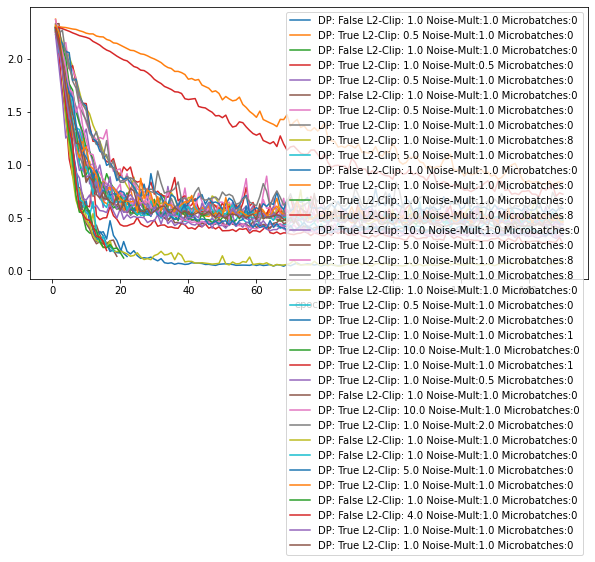

In [6]:
# Test Loss Plot
fig, ax = plt.subplots(figsize=(10, 5))
for params, df in experiments:
    df.plot(x="epoch", y="test_loss", ax=ax, label=f'DP: {params["local_dp"]} L2-Clip: {params["l2_norm_clip"]} Noise-Mult:{params["noise_multiplier"]} Microbatches:{params["num_microbatches"]}')
fig.savefig(log_directory / "test_loss.pdf")

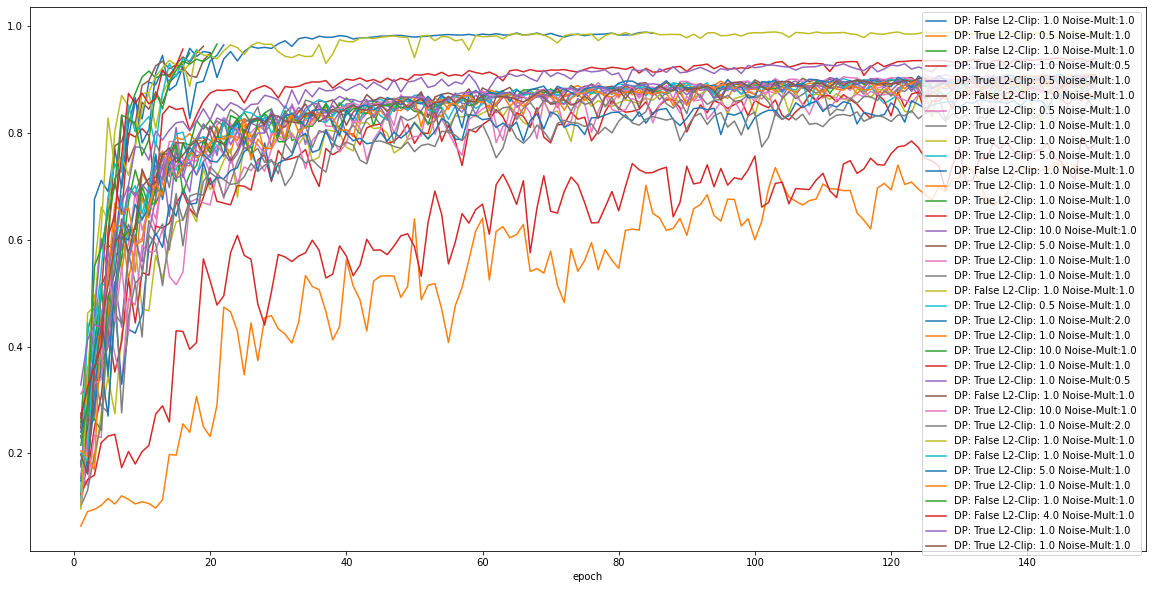

In [7]:
# Test Accuracy Plot
fig, ax = plt.subplots(figsize=(20, 10))
for params, df in experiments:
    df.plot(x="epoch", y="test_accuracy", ax=ax, label=f'DP: {params["local_dp"]} L2-Clip: {params["l2_norm_clip"]} Noise-Mult:{params["noise_multiplier"]}')
fig.savefig(log_directory / "test_accuracy.pdf")

In [3]:
from tensorflow_privacy import get_privacy_spent

# Eps Guarantees
privacy_dfs = []
privacy_params = []
for params, df in [exp for exp in experiments if exp[0]["local_dp"] == "True"]:
    df = df.copy()
    df["privacy_params"] =  f'{params["l2_norm_clip"]}_{params["noise_multiplier"]}'
    df["noise_multiplier"] = params["noise_multiplier"]
    df["l2_norm_clip"] = params["l2_norm_clip"]
    df["num_microbatches"] = params["num_microbatches"]
    df["privacy_guarantees"] = df.privacy_guarantees.map(lambda x: x.replace("'", "")).map(json.loads)
    eps_per_round_and_client = df["privacy_guarantees"][0][0]['eps']
    delta_per_round_and_client = df["privacy_guarantees"][0][0]['delta']
    df["eps_per_round_and_client"] = eps_per_round_and_client
    df["delta_per_round_and_client"] = delta_per_round_and_client
    df["eps_delta_per_round_and_client"] = f"({eps_per_round_and_client}, {delta_per_round_and_client})"
    dfp = df
    try:
        dfp["rdp"] = dfp["privacy_guarantees"].map(lambda client_results: np.array(client_results[0]["rdp"]))
        dfp["orders"] = dfp["privacy_guarantees"].map(lambda client_results: np.array(client_results[0]["orders"]))
        dfp["delta"] = dfp["privacy_guarantees"].map(lambda client_results: client_results[0]["delta"])
        dfp["rdp_cumsum"] = dfp.rdp.cumsum()
        dfp["cum_privacy"] = dfp[["orders", "rdp_cumsum", "delta"]].apply(lambda row: get_privacy_spent(row[0], row[1], target_delta=row[2]), axis=1)
        dfp["cum_eps"] = dfp["cum_privacy"].apply(lambda x: x[0])
        client_pick_prob = float(params["clients_per_round"]) / float(params["devices"])
        dfp["cum_eps_div"] = dfp["cum_eps"] * client_pick_prob
        dfp["eps_round_"] = dfp["privacy_guarantees"].map(lambda client_results: np.array(client_results[0]["eps"]))
        dfp["eps_naive_cumsum"] = dfp["eps_round_"].cumsum()
        dfp["delta_naive_cumsum"] = dfp["delta"].cumsum()
        dfp["eps_naive_cumsum_div"] = dfp["eps_naive_cumsum"] * client_pick_prob
        dfp["delta_naive_cumsum_div"] = dfp["delta_naive_cumsum"] * client_pick_prob
        privacy_dfs.append(df)
        privacy_params.append(params)
    except KeyError:
        pass
combined_df = pd.concat(privacy_dfs)

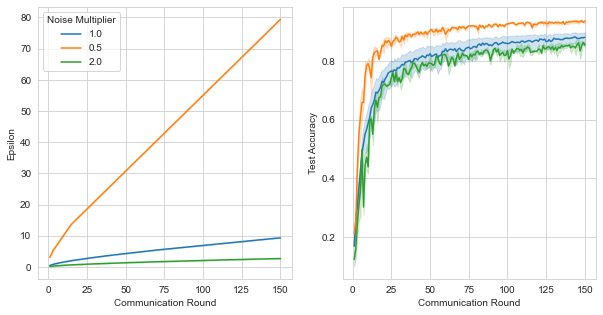

In [4]:
sns.set_style("whitegrid")
fig, (ax, ax2) = plt.subplots(nrows=1, ncols=2, sharex=True, figsize=(10, 5))
l = sns.lineplot(x="epoch", y="cum_eps_div", data=combined_df, ax=ax, hue="noise_multiplier")
l.legend().set_title("Noise Multiplier")
ax.set_ylabel("Epsilon")
ax.set_xlabel("Communication Round")
ax2.set_ylabel("Test Accuracy")
ax2.set_xlabel("Communication Round")
sns.lineplot(x="epoch", y="test_accuracy", ax=ax2, data=combined_df, hue="noise_multiplier")
ax2.get_legend().remove()
fig.savefig(log_directory / "noise_mult_eps_acc_tradeoff.pdf", bbox_inches = 'tight')

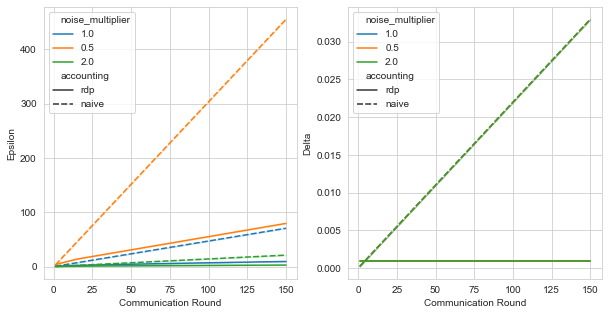

In [5]:
sns.set_style("whitegrid")
df1_ = combined_df.copy()
df2_ = combined_df.copy()

df1_["eps"] = df1_["cum_eps_div"]
df2_["eps"] = df2_["eps_naive_cumsum_div"]
df2_["delta"] = df2_["delta_naive_cumsum_div"]
df1_["accounting"] = "rdp"
df2_["accounting"] = "naive"

df_ = pd.concat([df1_, df2_])
fig, (ax, ax2) = plt.subplots(nrows=1, ncols=2, sharex=True, figsize=(10, 5))
l = sns.lineplot(x="epoch", y="eps", data=df_, ax=ax, hue="noise_multiplier", style="accounting")
ax.set_ylabel("Epsilon")
ax.set_xlabel("Communication Round")
sns.lineplot(x="epoch", y="delta", data=df_, ax=ax2, hue="noise_multiplier", style="accounting")
ax2.set_ylabel("Delta")
ax2.set_xlabel("Communication Round")

fig.savefig(log_directory / "accounting_naive_vs_rdp.pdf", bbox_inches = 'tight')

<AxesSubplot:xlabel='epoch', ylabel='test_accuracy'>

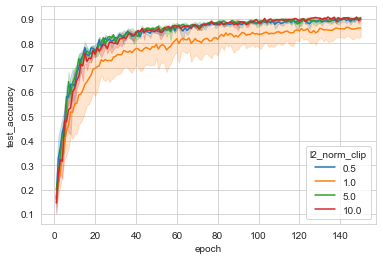

In [6]:
dfp_ = combined_df[combined_df["noise_multiplier"] == "1.0"]
fig, ax = plt.subplots()
sns.lineplot(x="epoch", y="test_accuracy", ax=ax, data=dfp_, hue="l2_norm_clip")

In [7]:
combined_df.columns

Index(['Unnamed: 0', 'test_loss', 'test_accuracy', 'epoch', 'devices',
       'epochs', 'local_epochs', 'clients_call_duration', 'clients_per_round',
       'client_histories', 'privacy_params', 'privacy_guarantees',
       'noise_multiplier', 'l2_norm_clip', 'num_microbatches',
       'eps_per_round_and_client', 'delta_per_round_and_client',
       'eps_delta_per_round_and_client', 'rdp', 'orders', 'delta',
       'rdp_cumsum', 'cum_privacy', 'cum_eps', 'cum_eps_div', 'eps_round_',
       'eps_naive_cumsum', 'delta_naive_cumsum', 'eps_naive_cumsum_div',
       'delta_naive_cumsum_div', 'mia-auc', 'mia-attacker-advantage'],
      dtype='object')

<AxesSubplot:xlabel='epoch', ylabel='test_accuracy'>

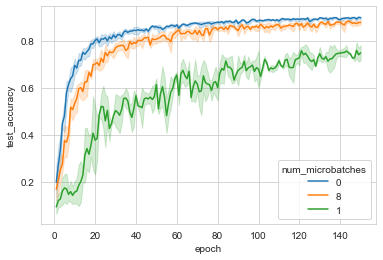

In [8]:
dfp_ = combined_df[combined_df["noise_multiplier"] == "1.0"]
dfp_ = dfp_[dfp_["l2_norm_clip"] == "1.0"]
fig, ax = plt.subplots()
sns.lineplot(x="epoch", y="test_accuracy", ax=ax, data=dfp_, hue="num_microbatches")

<AxesSubplot:xlabel='num_microbatches', ylabel='clients_call_duration'>

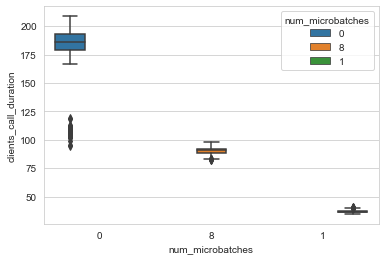

In [9]:
dfp_ = combined_df[combined_df["noise_multiplier"] == "1.0"]
dfp_ = dfp_[dfp_["l2_norm_clip"] == "1.0"]

fig, ax = plt.subplots()
sns.boxplot(y="clients_call_duration", x="num_microbatches", hue="num_microbatches", ax=ax, data=dfp_)
# clients_call_duration

<AxesSubplot:xlabel='epoch', ylabel='mia-attacker-advantage'>

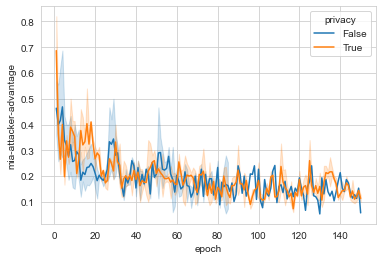

In [13]:
non_priv_mia_dfs = []
for params, df in [exp for exp in experiments if exp[0]["local_dp"] == "False" and exp[0]["local_epochs"] == "5" and exp[0]["local_batch_size"] == "16"]:
    non_priv_mia_dfs.append(df)
non_priv_mia_df = pd.concat(non_priv_mia_dfs)
non_priv_mia_df["privacy"] = False
#fig, ax = plt.subplots()
#sns.lineplot(x="epoch", y="mia-attacker-advantage", ax=ax, data=non_priv_mia_df)


dfp_ = combined_df[combined_df["noise_multiplier"] == "1.0"]
dfp_ = dfp_[dfp_["l2_norm_clip"] == "1.0"]
dfp_["privacy"] = True

df_ = pd.concat((dfp_, non_priv_mia_df))
fig, ax = plt.subplots()
sns.lineplot(x="epoch", y="mia-attacker-advantage", ax=ax, data=df_, hue="privacy")

0.9656999707221984
0.9503999948501588
0.9628000259399414
0.989300012588501
0.9308000206947328
0.9501000046730042
0.989799976348877
0.95660001039505
0.9668999910354614
0.9575999975204468


<AxesSubplot:xlabel='epoch', ylabel='mia-attacker-advantage'>

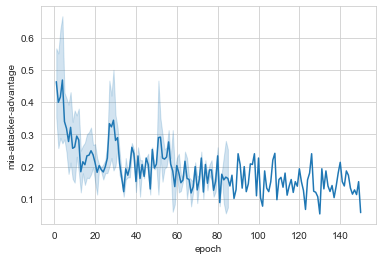

In [11]:
non_priv_mia_dfs = []
for params, df in [exp for exp in experiments if exp[0]["local_dp"] == "False" and exp[0]["local_epochs"] == "5" and exp[0]["local_batch_size"] == "16"]:
    non_priv_mia_dfs.append(df)
    print(df["test_accuracy"].max())
non_priv_mia_df = pd.concat(non_priv_mia_dfs)
fig, ax = plt.subplots()
sns.lineplot(x="epoch", y="mia-attacker-advantage", ax=ax, data=non_priv_mia_df)